# Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import time

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Converting MNIST images into 4D Tensors

In [3]:
transform = transforms.ToTensor()

# Setting up Training Data MNIST

In [4]:
train_data = datasets.MNIST(root="MNIST_CNN_data",train=True, download=True,transform=transform)

# Setting up Test Data

In [5]:
test_data = datasets.MNIST(root="MNIST_CNN_data",train=False, download=True,transform=transform)

### Verification train and test data MNIST data set

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_CNN_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST_CNN_data
    Split: Test
    StandardTransform
Transform: ToTensor()

# Creating train and test loader

In [8]:
train_loader = DataLoader(train_data, batch_size =10, shuffle=True)

test_loader = DataLoader(test_data, batch_size =10, shuffle=False)

# Define CNN Model

In [9]:
# 2 convolutional layers

conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

# Grabbing 1 MNIST record

In [10]:
for i, (X_Train, y_train) in enumerate(train_data):
    break

In [11]:
X_Train.shape

torch.Size([1, 28, 28])

In [12]:
x = X_Train.view(1,1,28,28)

# Performing first convolution

In [13]:
x = F.relu(conv1(x))

In [14]:
# 1 single image, 6 filters, 26x26 is image size 
# padding off so that is why image size is smaller
x.shape

torch.Size([1, 6, 26, 26])

In [15]:
# pass through the pooling layer

x = F.max_pool2d(x, 2,2)

In [16]:
x.shape

torch.Size([1, 6, 13, 13])

# Second convolutional layer

In [17]:
x = F.relu(conv2(x))

In [18]:
x.shape

torch.Size([1, 16, 11, 11])

# Second pooling layer

In [19]:
x= F.max_pool2d(x,2,2)

In [20]:
x.shape

torch.Size([1, 16, 5, 5])

# CNN Model Class

In [21]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        
        # Fully Connected layer
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    # Forward function    
    def forward(self, X):
        
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2
        
        # Second pass
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2
        
        # Re-view data to flatten it out
        
        X = X.view(-1, 16*5*5) # -1 so we can vary batch size
        
        # Fully Connected Layers
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim = 1)

# Creating instance model

In [22]:
torch.manual_seed(41)

model = ConvolutionalNetwork()

model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Loss Function Optimizer

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Smaller learning rate longer training time 

# Training and testing CNN Model

In [24]:
start_time = time.time()

# Creating Variables to track process

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Creating For loops of epochs

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Train
    for b,(X_train, y_train) in enumerate(train_loader):
        # Start batches at 1
        b+=1 
        # get predicted values from training set
        y_pred = model(X_train)
        # keep track of loss and comparing predictions to y_train
        loss = criterion(y_pred, y_train)
        
        # add up number of correct predictions, indexed off first point
        predicted = torch.max(y_pred.data,1)[1]
        # how many correct predictions from specific batch
        batch_corr = (predicted == y_train).sum()
        # keep track as we go along in training
        trn_corr += batch_corr
        
        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print out some results
        if b%600 == 0:
            print(f"Epoch: {i} Batch: {b} Loss: {loss.item()}")
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # Test
    # no gradient to avoid updating weights and biases with test data
    
    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            # Adding up correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
            
current_time = time.time()

total = current_time - start_time

print(f"Training Took: {total/60} minutes!")

Epoch: 0 Batch: 600 Loss: 0.1599932163953781
Epoch: 0 Batch: 1200 Loss: 0.18239684402942657
Epoch: 0 Batch: 1800 Loss: 0.5899779796600342
Epoch: 0 Batch: 2400 Loss: 0.15984275937080383
Epoch: 0 Batch: 3000 Loss: 0.007710675243288279
Epoch: 0 Batch: 3600 Loss: 0.3152642250061035
Epoch: 0 Batch: 4200 Loss: 0.005357618443667889
Epoch: 0 Batch: 4800 Loss: 0.0018775658681988716
Epoch: 0 Batch: 5400 Loss: 0.03922880440950394
Epoch: 0 Batch: 6000 Loss: 0.00036034564254805446
Epoch: 1 Batch: 600 Loss: 0.00790735799819231
Epoch: 1 Batch: 1200 Loss: 0.23831406235694885
Epoch: 1 Batch: 1800 Loss: 0.0020582634024322033
Epoch: 1 Batch: 2400 Loss: 0.005738230422139168
Epoch: 1 Batch: 3000 Loss: 0.024371806532144547
Epoch: 1 Batch: 3600 Loss: 0.28462880849838257
Epoch: 1 Batch: 4200 Loss: 0.02578127756714821
Epoch: 1 Batch: 4800 Loss: 0.0023505399003624916
Epoch: 1 Batch: 5400 Loss: 0.0002292245189892128
Epoch: 1 Batch: 6000 Loss: 0.2366952896118164
Epoch: 2 Batch: 600 Loss: 0.10125918686389923
Epoch

# Graphing CNN results

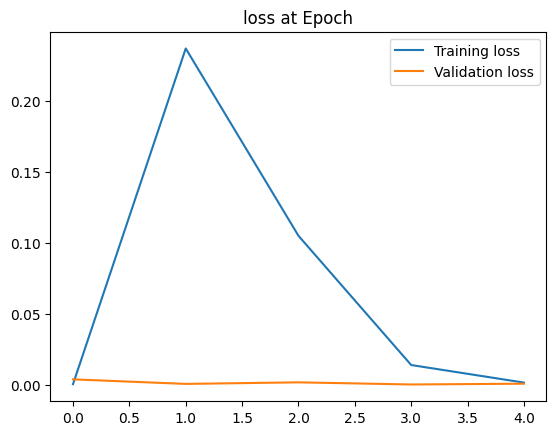

In [25]:
# Graphing loss at epoch

train_losses = [tl.item() for tl in train_losses]

plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("loss at Epoch")
plt.legend()

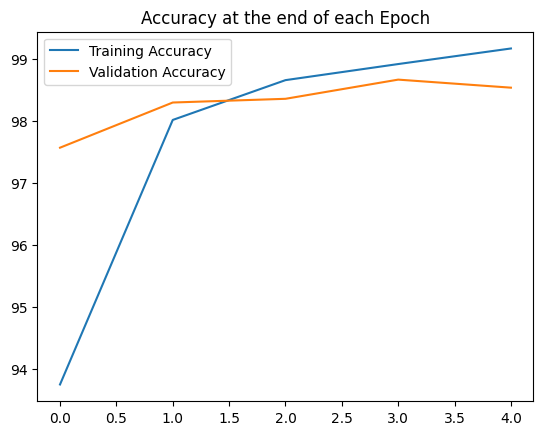

In [36]:
# Graphing accuracy at the end of each epoch

plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [28]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle= False)

In [30]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [35]:
print(f"Accuracy test load = {correct.item()/len(test_data)*100} %")

Accuracy test load = 98.54 %


# Grabbing an Image

In [38]:
test_data[4143]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

# Grab just the data

In [39]:
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

# Reshaping test_data

In [41]:
reshape_test = test_data[4143][0].reshape(28,28)

# Showing image

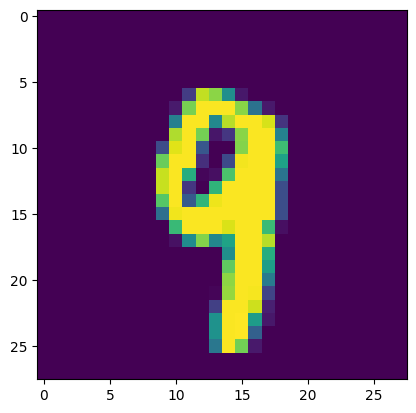

In [42]:
plt.imshow(reshape_test)

# Passing image through model

In [43]:
model.eval()
with torch.no_grad():
    new_prediction = model(reshape_test.view(1,1,28,28))

In [44]:
new_prediction.argmax()

tensor(9)